## Import Libraries

In [48]:
import os
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from cv2 import resize as cv2_resize
from librosa import load as lib_load
from librosa import feature as lib_feature
import librosa

# Import sci-kit models
from sklearn.preprocessing import OneHotEncoder , RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

## Load Data

In [2]:
# Launch Jupyter Notebook from the project folder
root_path = os.getcwd()
# Data is stored in the folder named "Data"
path = os.path.join(root_path, 'Data')

In [30]:
def load_data(path, sample_rate):
    # Create data lists
    samples = []
    labels = []
    classes = os.listdir(path)
    print('Loading data...')

    for file in os.listdir(path):
        class_path = os.path.join(path, file)
        for filename in os.listdir(class_path):
            # Load data
            y, s = lib_load(os.path.join(class_path,filename), sr=sample_rate)
            # Append data and label
            labels.append([file])
            samples.append(y)
            #print('Loaded {}'.format(filename))
            
    return samples, classes, labels

In [96]:
# Define sample rate
sample_rate = 44_100
# Load data
samples, classes, labels = load_data(path, sample_rate)
# Save full data set if samples is overwritten (sub-sampling) later
full_samples = samples

# Print data information
print('Loaded data from the directory {} \n'.format(path))
print('Loaded the classes: {} \n'.format(classes))
print('Loaded {} samples with {} labels \n'.format(len(samples), len(labels)))

# Check lengths of samples and their labels
for idx, sample in enumerate(samples):
  print('Sample {:2}: \t {:.1f}s \t {}'.format(idx, len(sample)/sample_rate, labels[idx]))

Loading data...
Loaded data from the directory C:\Users\14w\Documents\CS522_final\Data 

Loaded the classes: ['Dendropsophus bifurcus', 'Engystomops petersi', 'Pristimantis conspicillatus'] 

Loaded 31 samples with 31 labels 

Sample  0: 	 105.8s 	 ['Dendropsophus bifurcus']
Sample  1: 	 593.1s 	 ['Dendropsophus bifurcus']
Sample  2: 	 45.9s 	 ['Dendropsophus bifurcus']
Sample  3: 	 29.4s 	 ['Dendropsophus bifurcus']
Sample  4: 	 105.8s 	 ['Dendropsophus bifurcus']
Sample  5: 	 240.3s 	 ['Dendropsophus bifurcus']
Sample  6: 	 313.6s 	 ['Dendropsophus bifurcus']
Sample  7: 	 409.2s 	 ['Dendropsophus bifurcus']
Sample  8: 	 208.7s 	 ['Dendropsophus bifurcus']
Sample  9: 	 317.8s 	 ['Dendropsophus bifurcus']
Sample 10: 	 512.6s 	 ['Engystomops petersi']
Sample 11: 	 419.5s 	 ['Engystomops petersi']
Sample 12: 	 368.0s 	 ['Engystomops petersi']
Sample 13: 	 320.0s 	 ['Engystomops petersi']
Sample 14: 	 641.0s 	 ['Engystomops petersi']
Sample 15: 	 1018.6s 	 ['Engystomops petersi']
Sample 1

### Plot Data

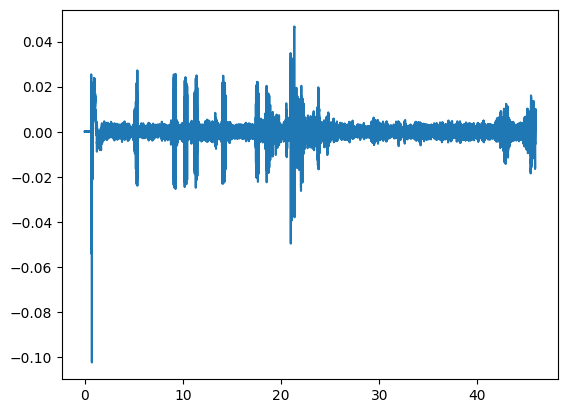

In [97]:
# Choose series to plot
sample = samples[2]
plt.plot(np.linspace(0, len(sample)/sample_rate, len(sample)), sample)

### Down-sample Data to 18 Seconds

In [78]:
# If True, data is down sampled. Specify subsampled time below.
if True:
    # Specify down-sample time in seconds and number of samples
    subsample_time = 18
    subsample_samples = subsample_time * sample_rate
    # Create sub-sampled data
    subsamples = []
    validation_samples = []
    for sample in full_samples:
        # Get correct indicies
        start = 0 #np.random.randint(0, len(sample) - subsample_samples)
        end = start + subsample_samples
        if end >= len(sample):
            start = start - 1
            end = end - 1
        # Create sub-sampled array
        subsamples.append(sample[start:end])
        # Create training matrix from remaining data by taking the longer of the remaining samples.
        # Training samples are not added to avoid creating splicing artifacts
        train1 = sample[0:start]
        train2 = sample[end:-1]
        if len(train1) > len(train2):
            validation_samples.append(train1)
        else:
            validation_samples.append(train2)

    # Overwrite samples data with subsamples
    samples = subsamples

## Encode labels

In [79]:
# Reshape classes list
unique_classes = [[c] for c in classes]

# Create encoder, fit, and check encoding
enc = OneHotEncoder()
enc.fit(unique_classes)
enc_labels = enc.transform(labels).toarray()
for idx, item in enumerate(enc_labels):
    print('Encoding is {}, label is {}'.format(enc_labels[idx], labels[idx]))

Encoding is [1. 0. 0.], label is ['Dendropsophus bifurcus']
Encoding is [1. 0. 0.], label is ['Dendropsophus bifurcus']
Encoding is [1. 0. 0.], label is ['Dendropsophus bifurcus']
Encoding is [1. 0. 0.], label is ['Dendropsophus bifurcus']
Encoding is [1. 0. 0.], label is ['Dendropsophus bifurcus']
Encoding is [1. 0. 0.], label is ['Dendropsophus bifurcus']
Encoding is [1. 0. 0.], label is ['Dendropsophus bifurcus']
Encoding is [1. 0. 0.], label is ['Dendropsophus bifurcus']
Encoding is [1. 0. 0.], label is ['Dendropsophus bifurcus']
Encoding is [1. 0. 0.], label is ['Dendropsophus bifurcus']
Encoding is [0. 1. 0.], label is ['Engystomops petersi']
Encoding is [0. 1. 0.], label is ['Engystomops petersi']
Encoding is [0. 1. 0.], label is ['Engystomops petersi']
Encoding is [0. 1. 0.], label is ['Engystomops petersi']
Encoding is [0. 1. 0.], label is ['Engystomops petersi']
Encoding is [0. 1. 0.], label is ['Engystomops petersi']
Encoding is [0. 1. 0.], label is ['Engystomops petersi']
E

## Get Spectrograms

In [80]:
def get_spectrograms(data, fft_size=1_024, sample_rate=44_100):
    ## Compute Fast Fourier Transform of data
    # Create FFT list
    f = []
    t = []
    pxx = []
    
    print("Calculating FFTs for data ...")
    for datum in data:
        f_idx, t_idx, pxx_idx = signal.spectrogram(datum, nperseg=fft_size, fs=sample_rate, noverlap=fft_size/2)
        
        f.append(f_idx)
        t.append(t_idx)
        pxx.append(pxx_idx)

    return f, t, pxx

In [81]:
# Specify FFT size
fft_size = 1024
# Load data
freqs, times, specs = get_spectrograms(samples, fft_size, sample_rate)

# Check spectrogram data shapes
print('Spectrograms: \t {}'.format(len(specs)))
print('Frequency bins: {} \n'.format(len(specs[0])))
for idx, spec in enumerate(specs):
    print('Spectrogram {} time bins: \t {}'.format(idx, len(spec[0])))

Calculating FFTs for data ...
Spectrograms: 	 31
Frequency bins: 513 

Spectrogram 0 time bins: 	 1032
Spectrogram 1 time bins: 	 1032
Spectrogram 2 time bins: 	 1032
Spectrogram 3 time bins: 	 1032
Spectrogram 4 time bins: 	 1032
Spectrogram 5 time bins: 	 1032
Spectrogram 6 time bins: 	 1032
Spectrogram 7 time bins: 	 1032
Spectrogram 8 time bins: 	 1032
Spectrogram 9 time bins: 	 1032
Spectrogram 10 time bins: 	 1032
Spectrogram 11 time bins: 	 1032
Spectrogram 12 time bins: 	 1032
Spectrogram 13 time bins: 	 1032
Spectrogram 14 time bins: 	 1032
Spectrogram 15 time bins: 	 1032
Spectrogram 16 time bins: 	 1032
Spectrogram 17 time bins: 	 1032
Spectrogram 18 time bins: 	 1032
Spectrogram 19 time bins: 	 1032
Spectrogram 20 time bins: 	 1032
Spectrogram 21 time bins: 	 1032
Spectrogram 22 time bins: 	 1032
Spectrogram 23 time bins: 	 1032
Spectrogram 24 time bins: 	 1032
Spectrogram 25 time bins: 	 1032
Spectrogram 26 time bins: 	 1032
Spectrogram 27 time bins: 	 1032
Spectrogram 28 

## Binning Data

In [82]:
def get_bins(data, num_freq_bins=5, num_time_bins=5):
    binned_data = []
        
    # Get individual samples
    for datum in data:
        #Open CV's resize takes (columns,rows) as the input for desired size
        resized_pxx=cv2_resize(datum[:,:],(num_time_bins,num_freq_bins))
        binned_data.append(resized_pxx.flatten())
            
    return binned_data

In [83]:
# Define bins
freq_bins = 5
time_bins = 5
# Get binned data
binned_specs = get_bins(specs, freq_bins, time_bins)

# Print bin shapes
print('Binned spectrograms: \t {}'.format(len(binned_specs)))
print('Number of bins: \t {}'.format(len(binned_specs[0])))

Binned spectrograms: 	 31
Number of bins: 	 25


## Get Windows

In [84]:
def get_time_windows(data, len_window=1, overlap=0, sample_rate=44_100):
    # Print values of windows
    print('Extracting time windows {}s long with {}% overlap. \n'.format(len_window, overlap*100))
    # Define window interval lengths and number of samples per interval
    interval_samples = len_window * sample_rate
    
    windows = []
    for idx, datum in enumerate(data):
        # Define sample time values
        total_time = len(datum) / sample_rate
        start_time = len_window * overlap
        overlap_time = len_window * overlap
        # Define vector of window center time values
        times = np.arange(start_time, total_time - overlap_time, len_window)

        # Create windows
        datum_windows = []
        for iidx, time in enumerate(times):
            low_time = interval_samples * iidx
            high_time = interval_samples * (iidx+1) - 1
            window = datum[low_time:high_time]
            datum_windows.append(window)
        
        windows.append(datum_windows)

    return windows

In [85]:
def get_freq_windows(data, len_window=1, overlap=0, sample_rate=44_100, fft_window=512):
    # Print values of windows
    print('Extracting frequency windows {}s long with {}% overlap. \n'.format(len_window, overlap*100))
    # Define samples per interval
    interval_samples = round(len_window * sample_rate / fft_window // 1)
    
    windows = []
    for idx, datum in enumerate(data):
        # Define sample time values
        total_time = datum.shape[1] * fft_window / sample_rate
        start_time = len_window * overlap
        overlap_time = len_window * overlap
        # Define vector of window center time values
        times = np.arange(start_time, total_time - overlap_time, len_window)

        # Create windows
        datum_windows = []
        for iidx, time in enumerate(times):
            low_time = interval_samples * iidx
            high_time = interval_samples * (iidx+1) - 1
            window = np.array(datum[:, low_time:high_time])
            datum_windows.append(window)
        
        windows.append(datum_windows)

    return windows

In [86]:
def get_windowed_labels(labels, windowed_data):
    # Initialize output list and iterate over non-windowed labels
    windowed_labels = []
    for idx, label in enumerate(labels):
        # Compute number of windows for sample associated with label
        num_windows = len(windowed_samples[idx])
        # Create list of label repeated for each window
        windowed_label = []
        for idx in range(0, num_windows):
            windowed_label.append(label)
            
        windowed_labels.append(windowed_label)
        
    return windowed_labels

In [87]:
# Define time windows of interest
len_window = 5
window_overlap = 0.5

# Get time windows
windowed_samples = get_time_windows(samples, len_window, window_overlap, sample_rate)
# Get frequency windows
windowed_specs = get_freq_windows(specs, len_window, window_overlap, sample_rate, fft_size/2)
# Get windowed labels
windowed_labels = get_windowed_labels(labels, windowed_samples)
# Get encoded windowed labels
enc_windowed_labels = get_windowed_labels(enc_labels, windowed_samples)

# Print data shapes
for idx, sample in enumerate(windowed_samples):
    print('Windows in sample {}: \t {}'.format(idx, len(sample)))

Extracting time windows 5s long with 50.0% overlap. 

Extracting frequency windows 5s long with 50.0% overlap. 

Windows in sample 0: 	 2
Windows in sample 1: 	 2
Windows in sample 2: 	 2
Windows in sample 3: 	 2
Windows in sample 4: 	 2
Windows in sample 5: 	 2
Windows in sample 6: 	 2
Windows in sample 7: 	 2
Windows in sample 8: 	 2
Windows in sample 9: 	 2
Windows in sample 10: 	 2
Windows in sample 11: 	 2
Windows in sample 12: 	 2
Windows in sample 13: 	 2
Windows in sample 14: 	 2
Windows in sample 15: 	 2
Windows in sample 16: 	 2
Windows in sample 17: 	 2
Windows in sample 18: 	 2
Windows in sample 19: 	 2
Windows in sample 20: 	 2
Windows in sample 21: 	 2
Windows in sample 22: 	 2
Windows in sample 23: 	 2
Windows in sample 24: 	 2
Windows in sample 25: 	 2
Windows in sample 26: 	 2
Windows in sample 27: 	 2
Windows in sample 28: 	 2
Windows in sample 29: 	 2
Windows in sample 30: 	 2


### Flatten windowed arrays, optional

In [88]:
def flatten_windows(samples):
    flat = []
    for sample in samples:
        for data in sample:
            flat.append(data)
            
    return flat

In [89]:
# Flatten windowed time series data, spectrograms, and labels if True
if True:
    windowed_samples = flatten_windows(windowed_samples)
    windowed_specs = flatten_windows(windowed_specs)
    windowed_labels = flatten_windows(windowed_labels)
    enc_windowed_labels = flatten_windows(enc_windowed_labels)
    print('Samples length: \t {}'.format(len(windowed_samples)))
    print('Spectrograms length: \t {}'.format(len(windowed_specs)))
    print('Labels length: \t {}'.format(len(windowed_labels)))

Samples length: 	 62
Spectrograms length: 	 62
Labels length: 	 62


## Feature Extraction

In [90]:
window_numbers = 20 ## need to be determined
domain_fv = []
FFT_size=fft_size

for i in range(len(samples)):
    #specs reshape: [frequency][time]
#     print('Initial spectrogram shape: \t {}'.format(specs[i].shape))
#     print('New specrogram length: \t {} \n'.format(specs_reshape[i].shape))

    # peak frequency

    # zero crossing rate
    # threshold crossing rate 

    # MFCC
    mfccs = lib_feature.mfcc(y=samples[i], sr=sample_rate, n_mfcc=10, win_length = int(np.ceil(FFT_size/window_numbers)), hop_length = int(np.ceil(FFT_size/(2*window_numbers))))
    mfccs_mean = np.mean(mfccs.T, axis=0)

    # Spectral Centroid
    sc = lib_feature.spectral_centroid(y=samples[i], sr=sample_rate, win_length = int(np.ceil(FFT_size/window_numbers)), hop_length = int(np.ceil(FFT_size/(2*window_numbers))))
    reshape_sc=[]
    for x in sc:
        for j in x:
            reshape_sc.append(j)
    max_sc = max(reshape_sc)
    min_sc = min(reshape_sc)
    mean_sc = np.mean(reshape_sc)
    sc_fv = [max_sc, min_sc, mean_sc]

    # Bandwidth
    bw = librosa.feature.spectral_bandwidth(y=samples[i], sr=sample_rate, win_length = int(np.ceil(FFT_size/window_numbers)), hop_length = int(np.ceil(FFT_size/(2*window_numbers))))
    reshape_bw=[]
    for x in bw:
        for j in x:
            reshape_bw.append(j)
    max_bw = max(reshape_bw)
    min_bw = min(reshape_bw)
    mean_bw = np.mean(reshape_bw)
    bw_fv = [max_bw, min_bw, mean_bw]

    # Combine all features for each sample
    all_fv = [mfccs_mean,sc_fv,bw_fv]
    reshape_fv=[]
    for x in all_fv:
        for j in x:
            reshape_fv.append(j)
            
    # Get features for all samples
    domain_fv.append(reshape_fv)

print('Features extracted')

Features extracted


## Train Model

### I . Using only feature data

#### Random Forest

In [91]:
# Specify which data to use, these are the only parameters that should change, the rest should remain the same.
X = domain_fv
y = enc_labels
depth = 5

# Convert X to numpy array if not imputing
X = np.asarray(X)
y = np.asarray(y)

# Define model
clf = RandomForestClassifier(max_depth=depth, random_state=0)

# Define number of folds
cv = StratifiedKFold(n_splits=10, shuffle=False)

# Split data, train and test model on 10 folds
split = 1
scores = []
confuse_mat = []
for train_index, test_index in cv.split(np.array(X), np.array(y.argmax(axis=1))):
    print(f"Split {split}/10...")
    x_train, y_train = X[train_index], y[train_index]
    x_test, y_test = X[test_index], y[test_index]
    
    
    # Fit model and evaluate it
    clf.fit(x_train, y_train)
    scores.append(clf.score(x_test, y_test))
    
    # Construct confusion matrix
    y_predict = clf.predict(x_test)
    confuse_mat.append(confusion_matrix(y_test.argmax(axis=1), y_predict.argmax(axis=1)))
    
    # Iterate
    split = split + 1
    
print("Mean accuracy:" + str(np.mean(scores)))

C:\Users\14w\Anaconda3\envs\ml3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


Split 1/10...
Split 2/10...
Split 3/10...
Split 4/10...
Split 5/10...
Split 6/10...
Split 7/10...
Split 8/10...
Split 9/10...
Split 10/10...
Mean accuracy:0.39999999999999997


#### SVM

In [92]:
# Specify which data to use, these are the only parameters that should change, the rest should remain the same.
X = domain_fv
y = enc_labels
y = y.argmax(axis=1)
depth = 5

# Convert X to numpy array if not imputing
X = np.asarray(X)
y = np.asarray(y)

# Define model
clf = SVC(kernel='linear',random_state = 0)

# Define number of folds
cv = StratifiedKFold(n_splits=10, shuffle=False)

# Split data, train and test model on 10 folds
split = 1
scores = []
confuse_mat = []
for train_index, test_index in cv.split(X,y):
    print(f"Split {split}/10...")
    x_train, y_train = X[train_index], y[train_index]
    x_test, y_test = X[test_index], y[test_index]
    
    
    # Fit model and evaluate it
    clf.fit(x_train, y_train)
    scores.append(clf.score(x_test, y_test))
    
    # Construct confusion matrix
    y_predict = clf.predict(x_test)
    confuse_mat.append(confusion_matrix(y_test, y_predict))
    
    # Iterate
    split = split + 1
    
print("Mean accuracy:" + str(np.mean(scores)))

C:\Users\14w\Anaconda3\envs\ml3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


Split 1/10...
Split 2/10...
Split 3/10...
Split 4/10...
Split 5/10...
Split 6/10...
Split 7/10...
Split 8/10...
Split 9/10...
Split 10/10...
Mean accuracy:0.4416666666666666


### II. Using binned data + feature data

In [93]:
# Combine features and binned data

all_features =[]
for i in range(len(domain_fv)):
    l=[domain_fv[i],list(binned_specs[i])]
    l=[item for sublist in l for item in sublist]
    all_features.append(l)
all_features=np.array(all_features, dtype = object)

In [94]:
## Normalize 

scaler = RobustScaler()
all_features = scaler.fit_transform(all_features)

In [95]:
# Specify which data to use, these are the only parameters that should change, the rest should remain the same.
X = binned_specs
y = enc_labels
depth = 5

# Convert X to numpy array if not imputing
X = np.asarray(X)
y = np.asarray(y)

# # Create our imputer to replace missing values with the mean 
# imp = SimpleImputer(missing_values=np.nan, strategy='mean')
# imp = imp.fit(X)
    
# # Impute our data
# X_imp = imp.transform(X)

# Define model
clf = RandomForestClassifier(max_depth=depth, random_state=0)

# Define number of folds
cv = StratifiedKFold(n_splits=10, shuffle=False)

# Split data, train and test model on 10 folds
split = 1
scores = []
confuse_mat = []
for train_index, test_index in cv.split(np.array(X), np.array(y.argmax(axis=1))):
    print(f"Split {split}/10...")
    x_train, y_train = X[train_index], y[train_index]
    x_test, y_test = X[test_index], y[test_index]
    
    
    # Fit model and evaluate it
    clf.fit(x_train, y_train)
    scores.append(clf.score(x_test, y_test))
    
    # Construct confusion matrix
    y_predict = clf.predict(x_test)
    confuse_mat.append(confusion_matrix(y_test.argmax(axis=1), y_predict.argmax(axis=1)))
    
    # Iterate
    split = split + 1
    
print("Mean accuracy:" + str(np.mean(scores)))

Split 1/10...


C:\Users\14w\Anaconda3\envs\ml3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


Split 2/10...
Split 3/10...
Split 4/10...
Split 5/10...
Split 6/10...
Split 7/10...
Split 8/10...
Split 9/10...
Split 10/10...
Mean accuracy:0.16666666666666666


## Save Model

In [ ]:
import pickle

pkl_filename = "pickle_model.pkl"

# Note, for now this will only store the file in volitle memory in the notebook
# To save permanently, most add file path to drive
with open(pkl_filename, 'wb') as file:
  pickle.dump(clf, file)

## Load Model

In [ ]:
with open(pkl_filename, 'rb') as file:
  pickle_model = pickle.load(file)

In [ ]:
# Test saved model
print(pickle_model.score(x_test, y_test))